# Libraries and plotting

In [1]:
# default libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
import time
import math

In [2]:
# plotting configuration
sns.set(style = 'darkgrid',
        font_scale = 1.4,
        rc = {"lines.linewidth": 2,
          "figure.figsize": (12, 8)})

sns.set_palette('Set2')

In [21]:
from tools import get_exponential_bins,compute_quantile_hist_data
from data_gen import generate_raw_data,get_binned_data

# Simulations

In [15]:
# generate raw data
raw_data = generate_raw_data(number_of_users = 60000)

# compute bin boundaries
bins_boundaries = get_exponential_bins(10, 600000, 100)

# bin raw data
binned_data = get_binned_data(raw_data, bins_boundaries)

In [16]:
number_of_buckets=20

In [17]:
# compute cookie buckets for the binned data
binned_data['Bucket ID'] = (
    binned_data['Client ID'] % number_of_buckets).astype('int')

# compute cookie buckets for the raw data
raw_data['Bucket ID'] = (
    raw_data['Client ID'] % number_of_buckets).astype('int')

In [19]:
# compute histogram data / total counts within each bucket
bucket_data = binned_data.groupby('Bucket ID').sum()
bucket_data = bucket_data.drop(axis=1, columns=['Client ID'])

# number of histogram bins
num_of_bins=len(bins_boundaries)

# compute tuples of endpoints for each interval for histogram bins
bins_tuples = [(0, bins_boundaries[0])] + [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins)]

# compute midpoints of each bin
bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]

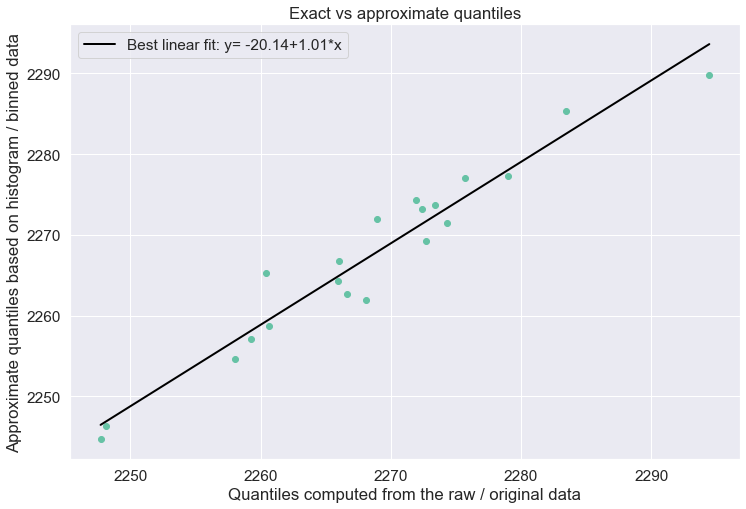

In [37]:
cur_quantile = 0.5

# obtain exact and approximate quantiles for a given level
appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=cur_quantile) for i in range(number_of_buckets)])
exact_quantiles = raw_data.groupby('Bucket ID').quantile(cur_quantile)['Metric Value'].values

# fit linear regression
reg = LinearRegression().fit(exact_quantiles.reshape(-1,1), appr_quantiles)

# plot the results
x_range = np.linspace(min(exact_quantiles), max(exact_quantiles))
plt.scatter(exact_quantiles,appr_quantiles)
plt.plot(x_range ,reg.intercept_ + reg.coef_ * x_range, color='black', label='Best linear fit: y= ' + 
    str(reg.intercept_.round(2)) +'+' +str(reg.coef_.round(2)[0])+"*x")
plt.ylabel('Approximate quantiles based on histogram / binned data')
plt.xlabel('Quantiles computed from the raw / original data')
plt.title('Exact vs approximate quantiles')
plt.legend()
plt.show()

In [28]:
reg.intercept_

-20.135181391337937

## Relative error in approximation (median, 95th, 99th)

In [61]:
approx_error_50=list()
approx_error_95=list()
approx_error_99=list()

number_of_obs = list()

In [62]:
number_of_clients = np.linspace(50,30000, 100)

In [63]:
for cur_number_of_clients in number_of_clients:
    # generate raw data
    raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
    number_of_obs+=[raw_data.shape[0]]

    # bin raw data
    binned_data = get_binned_data(raw_data, bins_boundaries)# generate raw data

    # compute cookie buckets for the binned data
    binned_data['Bucket ID'] = (
        binned_data['Client ID'] % number_of_buckets).astype('int')

    # compute cookie buckets for the raw data
    raw_data['Bucket ID'] = (
        raw_data['Client ID'] % number_of_buckets).astype('int')

    # compute histogram data / total counts within each bucket
    bucket_data = binned_data.groupby('Bucket ID').sum()
    bucket_data = bucket_data.drop(axis=1, columns=['Client ID'])

    # number of histogram bins
    num_of_bins=len(bins_boundaries)

    # compute tuples of endpoints for each interval for histogram bins
    bins_tuples = [(0, bins_boundaries[0])] + [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins)]

    # compute midpoints of each bin
    bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]

    # median 
    appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=0.5) for i in range(number_of_buckets)])
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
    approx_error_50+= [np.linalg.norm(exact_quantiles-appr_quantiles)/np.linalg.norm(exact_quantiles)]
    
    # 95th
    appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=0.95) for i in range(number_of_buckets)])
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
    approx_error_95+= [np.linalg.norm(exact_quantiles-appr_quantiles)/np.linalg.norm(exact_quantiles)]
    
    # 99th
    appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=0.99) for i in range(number_of_buckets)])
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
    approx_error_99+= [np.linalg.norm(exact_quantiles-appr_quantiles)/np.linalg.norm(exact_quantiles)]

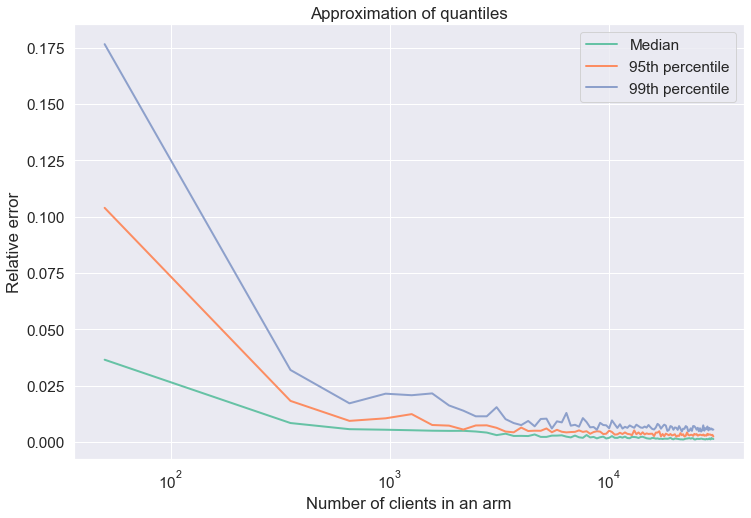

In [67]:
plt.plot(number_of_clients, approx_error_50, label='Median', )
plt.plot(number_of_clients, approx_error_95, label='95th percentile')
plt.plot(number_of_clients, approx_error_99, label='99th percentile')
plt.xscale('log')
plt.ylabel('Relative error')
plt.xlabel('Number of clients in an arm')
plt.title('Approximation of quantiles')
plt.legend()
plt.show()

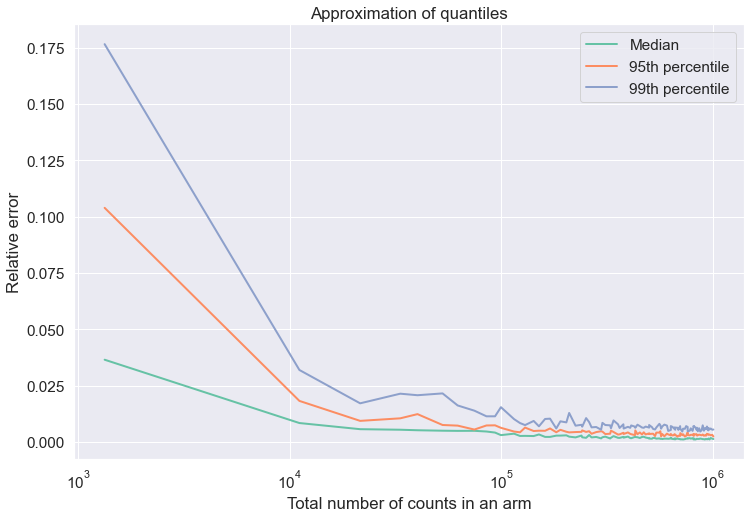

In [66]:
plt.plot(number_of_obs, approx_error_50, label='Median', )
plt.plot(number_of_obs, approx_error_95, label='95th percentile')
plt.plot(number_of_obs, approx_error_99, label='99th percentile')
plt.xscale('log')
plt.ylabel('Relative error')
plt.xlabel('Total number of counts in an arm')
plt.title('Approximation of quantiles')
plt.legend()
plt.show()

### number of users on a log-scale

In [80]:
log_number_of_clients = np.logspace(1.69,4.7, 100)

In [78]:
log_approx_error_50=list()
log_approx_error_95=list()
log_approx_error_99=list()

log_number_of_obs = list()

In [79]:
for cur_number_of_clients in log_number_of_clients:
    # generate raw data
    raw_data = generate_raw_data(number_of_users =int(cur_number_of_clients))
    log_number_of_obs+=[raw_data.shape[0]]

    # bin raw data
    binned_data = get_binned_data(raw_data, bins_boundaries)

    # compute cookie buckets for the binned data
    binned_data['Bucket ID'] = (
        binned_data['Client ID'] % number_of_buckets).astype('int')

    # compute cookie buckets for the raw data
    raw_data['Bucket ID'] = (
        raw_data['Client ID'] % number_of_buckets).astype('int')

    # compute histogram data / total counts within each bucket
    bucket_data = binned_data.groupby('Bucket ID').sum()
    bucket_data = bucket_data.drop(axis=1, columns=['Client ID'])

    # number of histogram bins
    num_of_bins=len(bins_boundaries)

    # compute tuples of endpoints for each interval for histogram bins
    bins_tuples = [(0, bins_boundaries[0])] + [(bins_boundaries[i-1], bins_boundaries[i]) for i in range(1, num_of_bins)]

    # compute midpoints of each bin
    bin_midpoints = [np.mean(bins_tuples[i]) for i in range(num_of_bins)]

    # median 
    appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=0.5) for i in range(number_of_buckets)])
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.5)['Metric Value'].values
    log_approx_error_50+= [np.linalg.norm(exact_quantiles-appr_quantiles)/np.linalg.norm(exact_quantiles)]
    
    # 95th
    appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=0.95) for i in range(number_of_buckets)])
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.95)['Metric Value'].values
    log_approx_error_95+= [np.linalg.norm(exact_quantiles-appr_quantiles)/np.linalg.norm(exact_quantiles)]
    
    # 99th
    appr_quantiles = np.array([compute_quantile_hist_data(bucket_data.loc[i].values, bins_tuples, quantile=0.99) for i in range(number_of_buckets)])
    exact_quantiles = raw_data.groupby('Bucket ID').quantile(0.99)['Metric Value'].values
    log_approx_error_99+= [np.linalg.norm(exact_quantiles-appr_quantiles)/np.linalg.norm(exact_quantiles)]

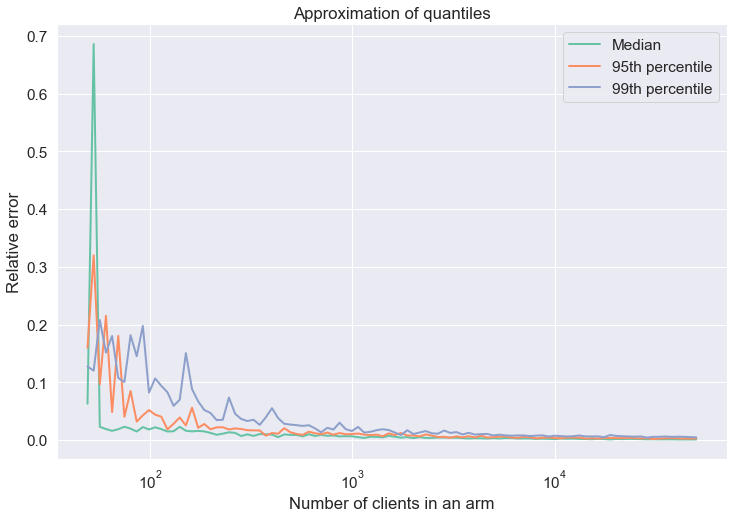

In [86]:
plt.plot(log_number_of_clients, log_approx_error_50, label='Median', )
plt.plot(log_number_of_clients, log_approx_error_95, label='95th percentile')
plt.plot(log_number_of_clients, log_approx_error_99, label='99th percentile')
plt.xscale('log')
plt.ylabel('Relative error')
plt.xlabel('Number of clients in an arm')
plt.title('Approximation of quantiles')
plt.legend()
plt.show()